In [8]:
import os
import sys
import warnings

import datetime
import math
import numpy as np
import pandas as pd
import platform
import re
import subprocess
import torch as th

import pickle
import gymnasium as gym
import matplotlib.pyplot as plt

from datetime import datetime
from scripts.utils import (
    load_scenario_data,
    verify_training_folders,
    create_results_directory,
    get_model_version,
    format_days,
    calculate_training_days,
    initialize_device,
    check_device_capabilities,
    get_device_info,
)
from scripts.visualizations import *
from src.config import *

from sb3_contrib import MaskablePPO
from stable_baselines3.common.logger import configure
from stable_baselines3.common.utils import polyak_update, set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from sb3_contrib.common.wrappers import ActionMasker  # Import ActionMasker wrapper

# Import your custom environment
from src.environment import AircraftDisruptionEnv

# Constants and Training Settings
LEARNING_RATE = 0.001
GAMMA = 0.99
BUFFER_SIZE = 50000 * 2
BATCH_SIZE = 64 * 4
TARGET_UPDATE_INTERVAL = 100
MAX_TIMESTEPS = 50000

NEURAL_NET_STRUCTURE = dict(net_arch=[256, 256 * 2, 256])
LEARNING_STARTS = 0
TRAIN_FREQ = 4

EPSILON_START = 1.0
EPSILON_MIN = 0.025
PERCENTAGE_MIN = 95

N_EPISODES = 500
CROSS_VAL_INTERVAL = 10  # This can be ignored for now since we're removing cross-validation

TRAINING_FOLDERS_PATH = '../data/Training/1k-3ac-12f-1dis-F/'
TESTING_FOLDERS_PATH = '../data/Testing/1k-3ac-12f-1dis-F/'  # Not used in this code version

# Initialize device
device = initialize_device()

# Check device capabilities
check_device_capabilities()

# Get device-specific information
device_info = get_device_info(device)
print(f"Device info: {device_info}")

# Verify training folders and gather training data
training_folders = verify_training_folders(TRAINING_FOLDERS_PATH)
print(f"Training folders: {training_folders}")

# Calculate training days and model naming
num_days_trained_on = calculate_training_days(N_EPISODES, training_folders)
print(f"Training on {num_days_trained_on} days of data "
      f"({N_EPISODES} episodes of {len(training_folders)} scenarios)")

formatted_days = format_days(num_days_trained_on)
last_folder = os.path.basename(os.path.normpath(TRAINING_FOLDERS_PATH))
model_name = last_folder
model_version = get_model_version(model_name)
MODEL_SAVE_PATH = f'../trained_models/'
MODEL_SAVE_NAME = f'{model_name}-{formatted_days}-{model_version}.zip'
print(f"Models will be saved to:")
print(f"   {MODEL_SAVE_PATH}myopic_{MODEL_SAVE_NAME}")
print(f"   {MODEL_SAVE_PATH}proactive_{MODEL_SAVE_NAME}")

# Create results directory
results_dir = create_results_directory()
print(f"Results directory created at: {results_dir}")

# Define the function to get action masks for the ActionMasker wrapper
def get_action_masks(env):
    return env.get_action_mask()

# Function to train PPO agent
def train_ppo_agent(env_type):
    # Initialize variables
    rewards = []
    total_timesteps = 0

    # List all the scenario folders in Training
    scenario_folders = [
        os.path.join(TRAINING_FOLDERS_PATH, folder)
        for folder in os.listdir(TRAINING_FOLDERS_PATH)
        if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))
    ]

    # Initialize the PPO agent
    # We will create a custom environment that cycles through the scenarios
    class ScenarioEnvWrapper(gym.Env):
        def __init__(self, scenario_folders, env_type):
            super(ScenarioEnvWrapper, self).__init__()
            self.scenario_folders = scenario_folders
            self.env_type = env_type
            self.current_scenario_idx = -1  # Will be incremented to 0 on first reset
            self.load_next_scenario()

            # Set observation and action spaces
            self.observation_space = self.env.observation_space
            self.action_space = self.env.action_space

        def load_next_scenario(self):
            self.current_scenario_idx = (self.current_scenario_idx + 1) % len(self.scenario_folders)
            scenario_folder = self.scenario_folders[self.current_scenario_idx]
            data_dict = load_scenario_data(scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            self.env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict,
                env_type=self.env_type
            )

        def reset(self, seed=None, options=None):
            self.load_next_scenario()
            result = self.env.reset(seed=seed, options=options)
            return result

        def step(self, action):
            return self.env.step(action)

        def render(self, mode='human'):
            return self.env.render(mode=mode)

        def close(self):
            return self.env.close()

        def seed(self, seed=None):
            self.env.seed(seed)

        def get_action_mask(self):
            return self.env.get_action_mask()

    # Create the environment
    env = ScenarioEnvWrapper(scenario_folders, env_type)

    # Wrap the environment with ActionMasker
    env = ActionMasker(env, get_action_masks)

    env = DummyVecEnv([lambda: env])

    # Create the MaskablePPO model
    model = MaskablePPO(
        'MultiInputPolicy',
        env,
        learning_rate=LEARNING_RATE,
        gamma=GAMMA,
        verbose=1,
        tensorboard_log=f"./ppo_aircraft_tensorboard_{env_type}/",
        device=device,
        policy_kwargs=NEURAL_NET_STRUCTURE
    )

    # Configure the logger
    logger = configure()
    model.set_logger(logger)

    # Training loop
    total_timesteps = 0
    timesteps_per_episode = MAX_TIMESTEPS // N_EPISODES
    for episode in range(N_EPISODES):
        # Train the model for a certain number of timesteps
        model.learn(total_timesteps=timesteps_per_episode, reset_num_timesteps=False)
        total_timesteps += timesteps_per_episode

        print(f"{env_type}: Episode {episode + 1}/{N_EPISODES} completed.")

    # Save the model after training
    model.save(f"{MODEL_SAVE_PATH}{env_type}_{MODEL_SAVE_NAME}")

    # Return collected data
    return rewards, total_timesteps

# Main code to train both agents and save results
start_time = datetime.now()

# Train the myopic PPO agent
results_myopic = train_ppo_agent('myopic')

# Train the proactive PPO agent
results_proactive = train_ppo_agent('proactive')

# Unpack the results
rewards_myopic, total_timesteps_myopic = results_myopic
rewards_proactive, total_timesteps_proactive = results_proactive

# Save the myopic rewards
myopic_rewards_file = os.path.join(results_dir, "rewards_myopic.pkl")
with open(myopic_rewards_file, "wb") as file:
    pickle.dump(rewards_myopic, file)
print(f"Myopic rewards saved to {myopic_rewards_file}")

# Save the proactive rewards
proactive_rewards_file = os.path.join(results_dir, "rewards_proactive.pkl")
with open(proactive_rewards_file, "wb") as file:
    pickle.dump(rewards_proactive, file)
print(f"Proactive rewards saved to {proactive_rewards_file}")

end_time = datetime.now()
runtime = end_time - start_time
runtime_in_seconds = runtime.total_seconds()
print(f"Total training time: {runtime_in_seconds} seconds")


Using device: mps
CUDA available: False
Number of GPUs available: 0
cuDNN enabled: True
Device: mps
Using MacBook M1
Device info: {'device_type': 'MacBook M1'}
Training folders: ['Scenario_264', 'Scenario_50', 'Scenario_432', 'Scenario_600', 'Scenario_290', 'Scenario_855', 'Scenario_899', 'Scenario_297', 'Scenario_607', 'Scenario_435', 'Scenario_57', 'Scenario_263', 'Scenario_852', 'Scenario_68', 'Scenario_638', 'Scenario_95', 'Scenario_61', 'Scenario_255', 'Scenario_631', 'Scenario_403', 'Scenario_890', 'Scenario_864', 'Scenario_404', 'Scenario_636', 'Scenario_252', 'Scenario_66', 'Scenario_92', 'Scenario_863', 'Scenario_59', 'Scenario_609', 'Scenario_897', 'Scenario_299', 'Scenario_239', 'Scenario_837', 'Scenario_662', 'Scenario_450', 'Scenario_32', 'Scenario_808', 'Scenario_206', 'Scenario_696', 'Scenario_468', 'Scenario_830', 'Scenario_691', 'Scenario_201', 'Scenario_35', 'Scenario_457', 'Scenario_665', 'Scenario_698', 'Scenario_806', 'Scenario_208', 'Scenario_495', 'Scenario_461',

In [9]:
import pickle


# Save the myopic rewards
myopic_rewards_file = os.path.join(results_dir, "rewards_myopic.pkl")
with open(myopic_rewards_file, "wb") as file:
    pickle.dump(rewards_myopic, file)
print(f"Myopic rewards saved to {myopic_rewards_file}")

# Save the proactive rewards
proactive_rewards_file = os.path.join(results_dir, "rewards_proactive.pkl")
with open(proactive_rewards_file, "wb") as file:
    pickle.dump(rewards_proactive, file)
print(f"Proactive rewards saved to {proactive_rewards_file}")

end_time = datetime.now()
runtime = end_time - start_time
runtime_in_seconds = runtime.total_seconds()
print(f"Total training time: {runtime_in_seconds} seconds")

Myopic rewards saved to ../results/20241122-00-08/rewards_myopic.pkl
Proactive rewards saved to ../results/20241122-00-08/rewards_proactive.pkl
Total training time: 16879.225003 seconds


In [10]:
from src.config import *

# Create a dictionary of all hyperparameters and system information
hyperparameters = {
    "Parameter": [
        "MODEL_TYPE",
        "LEARNING_RATE", "GAMMA", "BUFFER_SIZE", "BATCH_SIZE",
        "TARGET_UPDATE_INTERVAL", "MAX_TIMESTEPS", "LEARNING_STARTS",
        "TRAIN_FREQ", "N_EPISODES", "NEURAL_NET_STRUCTURE",
        "TRAINING_FOLDERS_PATH", "TESTING_FOLDERS_PATH", "MODEL_SAVE_PATH",
        "MODEL_SAVE_NAME", "runtime_in_seconds", "runtime_in_hh:mm:ss",
        "total_timesteps_myopic", "total_timesteps_proactive", "device",
        "device_info", "MAX_AIRCRAFT", "MAX_FLIGHTS_PER_AIRCRAFT",
        "TIMESTEP_HOURS", "DUMMY_VALUE", "RESOLVED_CONFLICT_REWARD",
        "DELAY_MINUTE_PENALTY", "MAX_DELAY_PENALTY", "NO_ACTION_PENALTY",
        "CANCELLED_FLIGHT_PENALTY", "MIN_TURN_TIME", "CROSS_VAL_INTERVAL",
        "PERCENTAGE_MIN"
    ],
    "Value": [
        "PPO", LEARNING_RATE, GAMMA, BUFFER_SIZE, BATCH_SIZE,
        TARGET_UPDATE_INTERVAL, MAX_TIMESTEPS, LEARNING_STARTS,
        TRAIN_FREQ, N_EPISODES, str(NEURAL_NET_STRUCTURE),
        TRAINING_FOLDERS_PATH, TESTING_FOLDERS_PATH, MODEL_SAVE_PATH,
        MODEL_SAVE_NAME, runtime_in_seconds, str(runtime),
        total_timesteps_myopic, total_timesteps_proactive, device,
        str(device_info), MAX_AIRCRAFT, MAX_FLIGHTS_PER_AIRCRAFT,
        TIMESTEP_HOURS, DUMMY_VALUE, RESOLVED_CONFLICT_REWARD,
        DELAY_MINUTE_PENALTY, MAX_DELAY_PENALTY, NO_ACTION_PENALTY,
        CANCELLED_FLIGHT_PENALTY, MIN_TURN_TIME, CROSS_VAL_INTERVAL,
        PERCENTAGE_MIN
    ]
}

# Convert the dictionary to a DataFrame
hyperparameters_df = pd.DataFrame(hyperparameters)

# Define the path for the CSV file
csv_file_path = os.path.join(results_dir, "hyperparameters.csv")

# Save the DataFrame to a CSV file
hyperparameters_df.to_csv(csv_file_path, index=False)
print(f"All hyperparameters saved to {csv_file_path}")


All hyperparameters saved to ../results/20241122-00-08/hyperparameters.csv


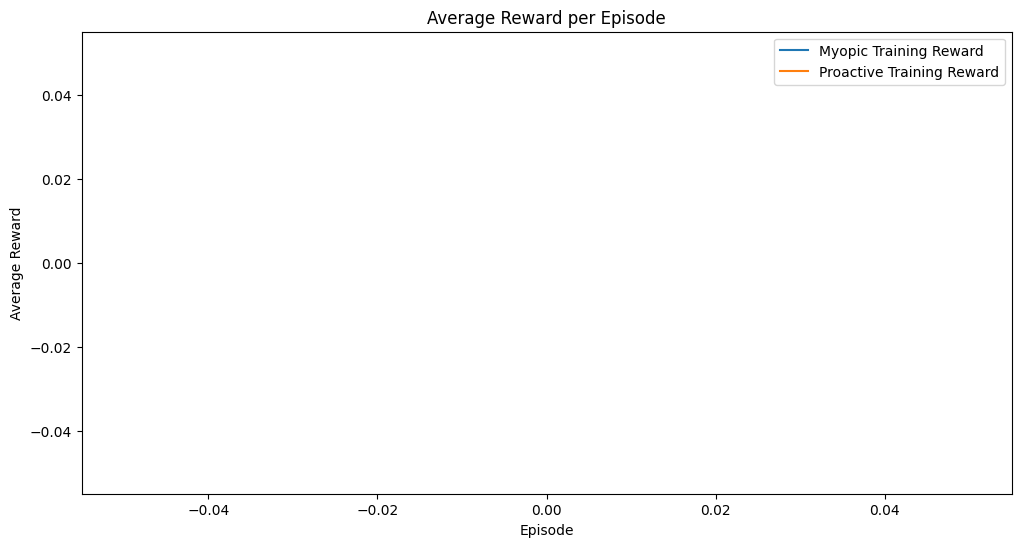

In [11]:
# Process training rewards per episode for myopic
episode_rewards_myopic = {}
for episode, scenario_folder, total_reward in rewards_myopic:
    if episode not in episode_rewards_myopic:
        episode_rewards_myopic[episode] = []
    episode_rewards_myopic[episode].append(total_reward)

avg_rewards_per_episode_myopic = []
episodes_myopic = []
for episode in sorted(episode_rewards_myopic.keys()):
    avg_reward = np.mean(episode_rewards_myopic[episode])
    avg_rewards_per_episode_myopic.append(avg_reward)
    episodes_myopic.append(episode + 1)  # episode numbers start from 0, so add 1

# Process training rewards per episode for proactive
episode_rewards_proactive = {}
for episode, scenario_folder, total_reward in rewards_proactive:
    if episode not in episode_rewards_proactive:
        episode_rewards_proactive[episode] = []
    episode_rewards_proactive[episode].append(total_reward)

avg_rewards_per_episode_proactive = []
episodes_proactive = []
for episode in sorted(episode_rewards_proactive.keys()):
    avg_reward = np.mean(episode_rewards_proactive[episode])
    avg_rewards_per_episode_proactive.append(avg_reward)
    episodes_proactive.append(episode + 1)  # episode numbers start from 0, so add 1

# Extract test rewards for myopic
# test_episodes_myopic = [ep for ep, _ in test_rewards_myopic]
# test_avg_rewards_myopic = [reward for _, reward in test_rewards_myopic]

# # Extract test rewards for proactive
# test_episodes_proactive = [ep for ep, _ in test_rewards_proactive]
# test_avg_rewards_proactive = [reward for _, reward in test_rewards_proactive]

# Plot the average rewards over the episodes
plt.figure(figsize=(12, 6))

# Plot training rewards
plt.plot(episodes_myopic, avg_rewards_per_episode_myopic, label='Myopic Training Reward', color='C0')
plt.plot(episodes_proactive, avg_rewards_per_episode_proactive, label='Proactive Training Reward', color='C1')


# plt.plot(test_episodes_myopic, test_avg_rewards_myopic, label='Myopic Test Reward', color='C0', linestyle='--')
# plt.plot(test_episodes_proactive, test_avg_rewards_proactive, label='Proactive Test Reward', color='C1', linestyle='--')

plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward per Episode')
plt.savefig(os.path.join(results_dir, 'plots', 'average_reward_per_episode.png'))
plt.show()
